In [ ]:
import pandas as pd
import numpy as np

# Manually creating the DataFrame based on the image data
data = {
    "SN": [170428, 180166, 180561, 190230, 190260, 300105, 310025, 310042, 310073, 310091, 310161, 310238, 310574, 320258, 330022],
    "Subsample": ["PS1"] * 15,
    "z": [0.3001, 0.1476, 0.2288, 0.1388, 0.1436, 0.0919, 0.1568, 0.2388, 0.1496, 0.5078, 0.2528, 0.2284, 0.2368, 0.3412, 0.2641],
    "mb": [21.81, 19.90, 21.43, 19.81, 19.58, 19.17, 19.72, 20.88, 19.69, 22.73, 21.85, 21.17, 21.00, 21.88, 21.24],
    "x1": [-0.99, 0.60, 0.01, -1.41, 0.98, 0.33, 1.85, 1.28, 0.38, -0.25, -0.44, -0.29, -0.62, -1.86, -1.25],
    "c": [-0.01, 0.04, 0.14, -0.07, -0.04, -0.08, -0.07, -0.05, 0.19, -0.09, -0.07, 0.02, 0.02, -0.06, 0.02],
    "μCorr": [-0.07, -0.02, -0.04, -0.01, -0.04, 0.08, 0.05, -0.03, 0.09, -0.08, -0.06, -0.09, -0.08, -0.01, -0.06],
    "Mass": [9.11, 10.88, 8.44, 10.87, 10.83, 9.87, 10.09, 11.64, 9.31, 9.07, 9.58, 9.31, 10.23, 10.05, 10.98]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Print the DataFrame to verify
print(df)

# Assuming the covariance matrix Sigma is identity for simplicity (you'll need the actual one)
Sigma = np.identity(df.shape[1] - 2)  # Size excluding SN and Subsample columns
mu = df[["z", "mb", "x1", "c", "μCorr", "Mass"]].mean().values

# Now, let's apply the likelihood function on the data
def log_likelihood(d, mu, Sigma):
    # Ensure inputs are numpy arrays
    d = np.array(d)
    mu = np.array(mu)
    Sigma = np.array(Sigma)
    
    # Compute the inverse of the covariance matrix
    Sigma_inv = np.linalg.inv(Sigma)
    
    # Compute the first term: -(1/2) * (d - mu)^T * Sigma_inv * (d - mu)
    diff = d - mu
    term1 = -0.5 * np.dot(np.dot(diff.T, Sigma_inv), diff)
    
    # Compute the second term: (1/2) * [(1^T * Sigma_inv * (d - mu))^2 / (1^T * Sigma_inv * 1)]
    ones = np.ones(len(d))
    Sigma_inv_ones = np.dot(Sigma_inv, ones)
    numerator = np.dot(ones.T, np.dot(Sigma_inv, diff)) ** 2
    denominator = np.dot(ones.T, Sigma_inv_ones)
    term2 = 0.5 * (numerator / denominator)
    
    # Compute the log-likelihood
    log_likelihood = term1 + term2
    
    return log_likelihood

# Apply log_likelihood for each row in the DataFrame
df["log_likelihood"] = df.apply(lambda row: log_likelihood(row[["z", "mb", "x1", "c", "μCorr", "Mass"]].values, mu, Sigma), axis=1)

# Print the DataFrame with log-likelihoods
print(df[["SN", "log_likelihood"]])


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

# Assuming the data DataFrame from previous steps
data = {
    "SN": [170428, 180166, 180561, 190230, 190260, 300105, 310025, 310042, 310073, 310091, 310161, 310238, 310574, 320258, 330022],
    "Subsample": ["PS1"] * 15,
    "z": [0.3001, 0.1476, 0.2288, 0.1388, 0.1436, 0.0919, 0.1568, 0.2388, 0.1496, 0.5078, 0.2528, 0.2284, 0.2368, 0.3412, 0.2641],
    "mb": [21.81, 19.90, 21.43, 19.81, 19.58, 19.17, 19.72, 20.88, 19.69, 22.73, 21.85, 21.17, 21.00, 21.88, 21.24],
    "x1": [-0.99, 0.60, 0.01, -1.41, 0.98, 0.33, 1.85, 1.28, 0.38, -0.25, -0.44, -0.29, -0.62, -1.86, -1.25],
    "c": [-0.01, 0.04, 0.14, -0.07, -0.04, -0.08, -0.07, -0.05, 0.19, -0.09, -0.07, 0.02, 0.02, -0.06, 0.02],
    "μCorr": [-0.07, -0.02, -0.04, -0.01, -0.04, 0.08, 0.05, -0.03, 0.09, -0.08, -0.06, -0.09, -0.08, -0.01, -0.06],
    "Mass": [9.11, 10.88, 8.44, 10.87, 10.83, 9.87, 10.09, 11.64, 9.31, 9.07, 9.58, 9.31, 10.23, 10.05, 10.98]
}

df = pd.DataFrame(data)

# Extract the parameters we want to plot
params = df[["z", "mb", "x1", "c", "μCorr", "Mass"]].values

# Define the log-likelihood function (simple normal likelihood for demonstration)
def log_likelihood(theta, params):
    mu, sigma = theta
    return -0.5 * np.sum(((params - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

# Define the prior (uniform for simplicity)
def log_prior(theta):
    mu, sigma = theta
    if 0 < sigma < 10:
        return 0.0
    return -np.inf

# Define the posterior probability
def log_probability(theta, params):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, params)

# Initialize the MCMC sampler
nwalkers, ndim = 50, 2  # 50 walkers, 2 parameters (mu, sigma)
initial = np.array([params.mean(), params.std()])
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(params,))

# Run the MCMC chain
sampler.run_mcmc(pos, 5000, progress=True);

# Get the samples and create the corner plot
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Create the corner plot
figure = corner.corner(samples, labels=["$\\mu$", "$\\sigma$"], truths=[params.mean(), params.std()])
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# Define the dataset
data = {
    "SN": [170428, 180166, 180561, 190230, 190260, 300105, 310025, 310042, 310073, 310091, 310161, 310238, 310574, 320258, 330022],
    "Subsample": ["PS1"] * 15,
    "z": [0.3001, 0.1476, 0.2288, 0.1388, 0.1436, 0.0919, 0.1568, 0.2388, 0.1496, 0.5078, 0.2528, 0.2284, 0.2368, 0.3412, 0.2641],
    "mb": [21.81, 19.90, 21.43, 19.81, 19.58, 19.17, 19.72, 20.88, 19.69, 22.73, 21.85, 21.17, 21.00, 21.88, 21.24],
    "x1": [-0.99, 0.60, 0.01, -1.41, 0.98, 0.33, 1.85, 1.28, 0.38, -0.25, -0.44, -0.29, -0.62, -1.86, -1.25],
    "c": [-0.01, 0.04, 0.14, -0.07, -0.04, -0.08, -0.07, -0.05, 0.19, -0.09, -0.07, 0.02, 0.02, -0.06, 0.02],
    "μCorr": [-0.07, -0.02, -0.04, -0.01, -0.04, 0.08, 0.05, -0.03, 0.09, -0.08, -0.06, -0.09, -0.08, -0.01, -0.06],
    "Mass": [9.11, 10.88, 8.44, 10.87, 10.83, 9.87, 10.09, 11.64, 9.31, 9.07, 9.58, 9.31, 10.23, 10.05, 10.98]
}

df = pd.DataFrame(data)

# Extract the parameters we want to plot
params = df[["z", "mb", "x1", "c", "μCorr", "Mass"]].values 

# Define the log-likelihood function using the given formula

def log_likelihood(theta, params, Sigma_inv):
    mu = theta
    ones = np.ones(params.shape[0])
    
    diff = params - mu
    term1 = -0.5 * np.dot(np.dot(diff.T, Sigma_inv), diff)
    
    Sigma_inv_ones = np.dot(Sigma_inv, ones)
    numerator = np.dot(ones.T, np.dot(Sigma_inv, diff)) ** 2
    denominator = np.dot(ones.T, Sigma_inv_ones)
    term2 = 0.5 * (numerator / denominator)
    
    return term1 + term2

# Define the prior (assuming a uniform prior for simplicity)
def log_prior(theta):
    if np.all(theta > 0) and np.all(theta < 100):
        return 0.0
    return -np.inf

# Define the posterior probability
def log_probability(theta, params, Sigma_inv):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, params, Sigma_inv)

# Covariance matrix and its inverse (assuming identity for simplicity, replace with actual covariance matrix)
Sigma = np.identity(params.shape[1])
Sigma_inv = np.linalg.inv(Sigma)

# Initialize the MCMC sampler
nwalkers, ndim = 50, params.shape[1]
initial = params.mean(axis=0)
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(params, Sigma_inv))

# Run the MCMC chain
sampler.run_mcmc(pos, 5000, progress=True)

# Get the samples and create the corner plot
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Create the corner plot
figure = corner.corner(samples, labels=["z", "mb", "x1", "c", "μCorr", "Mass"], truths=params.mean(axis=0))
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

# Define the dataset

# Read the data from the file
file_path = './lcparam_full_long.txt'
df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None, names=['name', 'zcmb', 'zhel', 'dz', 'mb', 'dmb', 'x1', 'dx1', 'color', 'dcolor', '3rdvar', 'd3rdvar', 'cov_m_s', 'cov_m_c', 'cov_s_c', 'set', 'ra', 'dec', 'biascor'])
#in this file I don't put the supernovae with strange names (last supernovae)


'''
x1: SALT2 light curve stretch parameter.
c: SALT2 light curve color parameter.
mb: SALT2 light curve peak magnitude in B band.
μCorr: Corrected distance modulus. 
Mass: Host galaxy stellar mass.
zcmb: CMB frame redshift.
zhel: Heliocentric redshift.
'''

# Extract the parameters we want to plot
params = df[["zcmb", "mb", "dmb", "x1","color"]].values #.values converts the name of the columns to a numpy array

# Define the log-likelihood function using the given formula
#Explanation of the likelihood:
'''
d is the data vector--> params (in the following function)
mu is the mean vector--> theta (in the following function)
sigma_inv is the inverse of the covariance matrix
'''
def log_likelihood(theta, params, Sigma_inv):
    mu = theta
    ones = np.ones(params.shape[0])
    
    diff = params - mu
    term1 = -0.5 * np.dot(np.dot(diff.T, Sigma_inv), diff)
    
    Sigma_inv_ones = np.dot(Sigma_inv, ones)
    numerator = np.dot(ones.T, np.dot(Sigma_inv, diff)) ** 2
    denominator = np.dot(ones.T, Sigma_inv_ones)
    term2 = 0.5 * (numerator / denominator)
    
    return term1 + term2

# Define the prior (assuming a uniform prior for simplicity)
def log_prior(theta):
    size_theta = len(theta)
    #create a vector of zero with the dimension fo theta
    zero_vector = np.zeros(size_theta)
    hundred_vector = 100*np.ones(size_theta)
    for i in range(size_theta):
        if np.all(theta > zero_vector) and np.all(theta < hundred_vector):
            return 0.0
    return -np.inf

# Define the posterior probability
#This is used to estimate the posterior distribution of the parameters given the data.
def log_probability(theta, params, Sigma_inv):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, params, Sigma_inv)

# Covariance matrix and its inverse (assuming identity for simplicity, replace with actual covariance matrix)
#for the sigma I put the error of mb: dmb
Sigma = np.diag(df['dmb']**2)
Sigma_inv = np.linalg.inv(Sigma)
#print(log_likelihood([0.1, 0.1, 0.1, 0.1, 0.1], params, Sigma_inv))
#print(log_probability([0.1, 0.1, 0.1, 0.1, 0.1], params, Sigma_inv))


# Initialize the MCMC sampler
nwalkers, ndim = 50, params.shape[1] #walkers are the number of chains and ndim is the number of parameters (nwalkers must be greater or equal than ndim)
initial = params.mean(axis=0)
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
#print(pos)
#print(1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(params, Sigma_inv))

# Run the MCMC chain
sampler.run_mcmc(pos, 5000, progress=True)
'''
# Get the samples and create the corner plot
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Create the corner plot
figure = corner.corner(samples, labels=["zcmb", "mb", "dmb"], truths=params.mean(axis=0))
plt.show()
'''


CHAT GPT 4

In [ ]:
import numpy as np
import emcee
import corner
import pandas as pd

# Read the data from the file
file_path = './lcparam_full_long.txt'
df = pd.read_csv(file_path, delim_whitespace=True, comment='#', header=None, names=['name', 'zcmb', 'zhel', 'dz', 'mb', 'dmb', 'x1', 'dx1', 'color', 'dcolor', '3rdvar', 'd3rdvar', 'cov_m_s', 'cov_m_c', 'cov_s_c', 'set', 'ra', 'dec', 'biascor'])
#in this file I don't put the supernovae with strange names (last supernovae)

# Constants
c = 299792.458  # speed of light in km/s

# Define the distance modulus function
def distance_modulus(z, H0, Om_m, w0, wa):
    # Placeholder for actual calculation
    # This should use a cosmological model to compute the theoretical distance modulus
    # For example, using the FLRW metric with dark energy parametrization
    return 5 * np.log10((1 + z) * c / H0) + 25

# Define the log-likelihood function
def log_likelihood(params, z, mb, dmb):
    H0, Om_m, w0, wa = params
    mu = distance_modulus(z, H0, Om_m, w0, wa)
    sigma2 = dmb ** 2
    diff = mb - mu
    return -0.5 * np.sum(diff ** 2 / sigma2 + np.log(sigma2))

# Prior transform function for uniform priors
def prior_transform(cube):
    H0 = 60 + cube[0] * 20
    Om_m = cube[1]
    w0 = -2 + cube[2] * 4
    wa = -2 + cube[3] * 4
    return H0, Om_m, w0, wa

# Load data
z = df['zcmb'].values
mb = df['mb'].values
dmb = df['dmb'].values

# Initialize the sampler
ndim = 4
nwalkers = 50
nsteps = 1000

initial = np.array([70, 0.3, -1, 0])
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(z, mb, dmb))
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Create the corner plot
fig = corner.corner(samples, labels=['H0', 'Om_m', 'w0', 'wa'], truths=[70, 0.3, -1, 0])
fig.savefig('/mnt/data/corner_plot.png')


ANOTHER TRY


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

# Step 1: Prepare the data
data = """
0 0.014 0.014 0.0 14.57001926 0.0311 0 0 0 0 0 0 0 0 0 0 0 0
1 0.0194 0.0194 0.0 15.2279603507 0.02645 0 0 0 0 0 0 0 0 0 0 0 0
2 0.0264 0.0264 0.0 15.934102317 0.0231 0 0 0 0 0 0 0 0 0 0 0 0
3 0.0329 0.0329 0.0 16.4217829558 0.0235 0 0 0 0 0 0 0 0 0 0 0 0
4 0.0396 0.0396 0.0 16.836418956 0.02845 0 0 0 0 0 0 0 0 0 0 0 0
5 0.0475 0.0475 0.0 17.2346439906 0.0334 0 0 0 0 0 0 0 0 0 0 0 0
6 0.056 0.056 0.0 17.5758459622 0.03215 0 0 0 0 0 0 0 0 0 0 0 0
7 0.064 0.064 0.0 17.9104543501 0.0439 0 0 0 0 0 0 0 0 0 0 0 0
8 0.0721 0.0721 0.0 18.1780074589 0.03865 0 0 0 0 0 0 0 0 0 0 0 0
9 0.0811 0.0811 0.0 18.5543855764 0.04225 0 0 0 0 0 0 0 0 0 0 0 0
10 0.0889 0.0889 0.0 18.7006554037 0.03635 0 0 0 0 0 0 0 0 0 0 0 0
11 0.1001 0.1001 0.0 19.0388242428 0.03515 0 0 0 0 0 0 0 0 0 0 0 0
12 0.1071 0.1071 0.0 19.1720185353 0.03355 0 0 0 0 0 0 0 0 0 0 0 0
13 0.1195 0.1195 0.0 19.3711295152 0.026 0 0 0 0 0 0 0 0 0 0 0 0
14 0.1278 0.1278 0.0 19.5555026238 0.02635 0 0 0 0 0 0 0 0 0 0 0 0
15 0.1396 0.1396 0.0 19.8185930766 0.02335 0 0 0 0 0 0 0 0 0 0 0 0
16 0.1519 0.1519 0.0 19.9445025196 0.0237 0 0 0 0 0 0 0 0 0 0 0 0
17 0.1635 0.1635 0.0 20.0642537602 0.02585 0 0 0 0 0 0 0 0 0 0 0 0
18 0.1778 0.1778 0.0 20.3389008923 0.01965 0 0 0 0 0 0 0 0 0 0 0 0
19 0.1906 0.1906 0.0 20.5047456137 0.02205 0 0 0 0 0 0 0 0 0 0 0 0
20 0.2067 0.2067 0.0 20.6854007995 0.0214 0 0 0 0 0 0 0 0 0 0 0 0
21 0.2216 0.2216 0.0 20.8610322507 0.0233 0 0 0 0 0 0 0 0 0 0 0 0
22 0.2405 0.2405 0.0 21.0518440051 0.0222 0 0 0 0 0 0 0 0 0 0 0 0
23 0.2558 0.2558 0.0 21.2037930719 0.02025 0 0 0 0 0 0 0 0 0 0 0 0
24 0.2762 0.2762 0.0 21.3636137766 0.0221 0 0 0 0 0 0 0 0 0 0 0 0
25 0.2972 0.2972 0.0 21.5790014334 0.0216 0 0 0 0 0 0 0 0 0 0 0 0
26 0.3215 0.3215 0.0 21.813277279 0.0214 0 0 0 0 0 0 0 0 0 0 0 0
27 0.3453 0.3453 0.0 21.9665751024 0.0234 0 0 0 0 0 0 0 0 0 0 0 0
28 0.3708 0.3708 0.0 22.1428940056 0.02145 0 0 0 0 0 0 0 0 0 0 0 0
29 0.4049 0.4049 0.0 22.3799192408 0.03225 0 0 0 0 0 0 0 0 0 0 0 0
30 0.4355 0.4355 0.0 22.5579272526 0.0254 0 0 0 0 0 0 0 0 0 0 0 0
31 0.4738 0.4738 0.0 22.797376642 0.02935 0 0 0 0 0 0 0 0 0 0 0 0
32 0.5174 0.5174 0.0 23.0011594448 0.02685 0 0 0 0 0 0 0 0 0 0 0 0
33 0.5742 0.5742 0.0 23.3004345026 0.0245 0 0 0 0 0 0 0 0 0 0 0 0
34 0.6299 0.6299 0.0 23.5036280324 0.031 0 0 0 0 0 0 0 0 0 0 0 0
35 0.724 0.724 0.0 23.8666293039 0.027 0 0 0 0 0 0 0 0 0 0 0 0
36 0.821 0.821 0.0 24.2445519795 0.0248 0 0 0 0 0 0 0 0 0 0 0 0
37 0.9511 0.9511 0.0 24.6411323707 0.0276 0 0 0 0 0 0 0 0 0 0 0 0
38 1.2336 1.2336 0.0 25.3039940191 0.05635 0 0 0 0 0 0 0 0 0 0 0 0
39 1.6123 1.6123 0.0 25.9259729107 0.0735 0 0 0 0 0 0 0 0 0 0 0 0
"""

# Parse the data
data_lines = data.strip().split("\n")
zcmb, mb, dmb = [], [], []
for line in data_lines:
    parts = line.split()
    zcmb.append(float(parts[1]))
    mb.append(float(parts[4]))
    dmb.append(float(parts[5]))

zcmb = np.array(zcmb)
mb = np.array(mb)
dmb = np.array(dmb)

# Step 2: Define the model and likelihood
def model(params, z):
    a, b = params
    return a * z + b

def log_likelihood(params, z, mb, dmb):
    model_mb = model(params, z)
    sigma2 = dmb ** 2
    return -0.5 * np.sum((mb - model_mb) ** 2 / sigma2 + np.log(sigma2))

# Step 3: Run MCMC
nwalkers = 50
ndim = 2
nsteps = 1000

# Initial guess
initial_guess = [0.5, 15.0]
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(zcmb, mb, dmb))
sampler.run_mcmc(pos, nsteps, progress=True)

samples = sampler.get_chain(discard=200, thin=15, flat=True)

# Step 4: Create corner plot
fig = corner.corner(samples, labels=["a", "b"], truths=[0.5, 15.0])
plt.show()


Mari's Programm

In [ ]:
import sys,platform,os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

#_camb_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'CAMB')
#sys.path.insert(0,_camb_path)

import camb
#print('Using CAMB %s installed at %s' %(camb.__version__,os.path.dirname(camb.__file__)))

# Load the data
file_path = 'binned_data.txt' #lcparam_full_long.txt, binned_data.txt

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Check the data and covariance matrix
print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

# Define the cosmological model
def get_mu(z, H0, Om0, w0, wa):
    # Configure CAMB parameters
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Om0, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        mu = get_mu(z, H0, Om0, w0, wa)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

# Define the log-posterior function
def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

# Modify the prior range for w0 to exclude values close to -1
def log_prior(params):
    H0, Om0, w0, wa = params
    if 0 < H0 < 100 and 0 < Om0 < 1 and -2 < w0 < -1.1 and -1 < wa < 0:
        return 0.0
    print(f"Invalid prior for params: {params}")
    return -np.inf


# Initialize the MCMC sampler
initial = np.array([70, 0.3, -0.9, 0.0])
ndim = len(initial)
nwalkers = 50
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Check initial likelihoods
print("Initial log-posterior values:")
for i in range(nwalkers):
    print(f"Walker {i}: {log_posterior(pos[i], data, Sigma_inv)}")

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 5  # Increase the number of steps
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])
plt.show()

new program of Mari

In [ ]:
import sys,platform,os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

_camb_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'CAMB')
sys.path.insert(0,_camb_path)

import camb
print('Using CAMB %s installed at %s' %(camb.__version__,os.path.dirname(camb.__file__)))

# Load the data
file_path = 'lcparam_full_long.txt' #binned_data.txt, lcparam_full_long.txt

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

# Check the data and covariance matrix
print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

# Define the cosmological model
def get_mu(z, H0, Om0, w0, wa):
    # Configure CAMB parameters
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    
    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

# Define the likelihood function
def ln_likelihood(params, data, cov_inv):
    H0, Om0, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        mu = get_mu(z, H0, Om0, w0, wa)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

# Define the log-posterior function
def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)


# Modify the prior range for w0 to exclude values close to -1
def log_prior(params):
    H0, Om0, w0, wa = params
    
    # Basic parameter bounds
    if not (60 < H0 < 80):
        #print(f"Invalid H0: {H0}")
        return -np.inf
    if not (0.2 < Om0 < 0.4):
        #print(f"Invalid Om0: {Om0}")
        return -np.inf
    if not (-1.3 < w0 < -0.8):
        #print(f"Invalid w0: {w0}")
        return -np.inf
    if not (-1 < wa < 0):
        #print(f"Invalid wa: {wa}")
        return -np.inf
    
    '''
    # Ensure w does not cross -1 at any redshift
    z = data['zcmb'].values
    w = w0 + wa * (z / (1 + z))
    if np.any(w > -1):
        crossing_indices = np.where(w > -1)[0]
        crossing_redshifts = z[crossing_indices]
        print(f"w is > -1 at redshifts: {crossing_redshifts}")
        return -np.inf
    '''
    '''
    # Constraint to avoid crossing w = -1 (relaxed)
    if w0 + wa < -1:
        print(f"w0 + wa < -1: {w0 + wa} -> invalid")
        return -np.inf
    if w0 + wa > -1:
        print(f"w0 + wa > -1: {w0 + wa} -> ok")
    '''
    return 0.0 #is it right ? 



# Initialize the MCMC sampler
initial = np.array([70, 0.3, -1.3, -0.3])
ndim = len(initial)
nwalkers = 50
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
'''
# Check initial likelihoods
print("Initial log-posterior values:")
for i in range(nwalkers):
    print(f"Walker {i}: {log_posterior(pos[i], data, Sigma_inv)}")
'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 500  # Increase the number of steps #500 prima 50
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100, thin=10, flat=True) #100, 10 prima: 200,5
'''
# Ensure there are enough samples
if samples.shape[0] == 0:
    raise ValueError("No samples to plot. Increase nsteps or adjust discard and thin values.")
'''
# Plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["H0", "Om0", "w0", "wa"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], color="k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlabel("Step number")

plt.tight_layout()
plt.show()

# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])
plt.show()

try to correct the program

Using CAMB 1.5.4 installed at /home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/camb
     name     zcmb     zhel   dz        mb      dmb  x1  dx1  color  dcolor  \
0  03D1au  0.50309  0.50309  0.0  22.93445  0.12605   0    0      0       0   
1  03D1ax  0.49480  0.49480  0.0  22.88020  0.11765   0    0      0       0   
2  03D1co  0.67767  0.67767  0.0  24.03770  0.20560   0    0      0       0   
3  03D1ew  0.86650  0.86650  0.0  24.34685  0.17385   0    0      0       0   
4  03D1fq  0.79857  0.79857  0.0  24.36050  0.17435   0    0      0       0   

   3rdvar  d3rdvar  cov_m_s  cov_m_c  cov_s_c  set  ra  dec  
0       0        0        0        0        0    0   0    0  
1       0        0        0        0        0    0   0    0  
2       0        0        0        0        0    0   0    0  
3       0        0        0        0        0    0   0    0  
4       0        0        0        0        0    0   0    0  
Covariance Matrix (Sigma):
[[0.0158886  0.        

  0%|          | 0/10000 [00:00<?, ?it/s]/home/andrewcats/anaconda3/envs/acc-env/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:41<00:00, 240.97it/s]


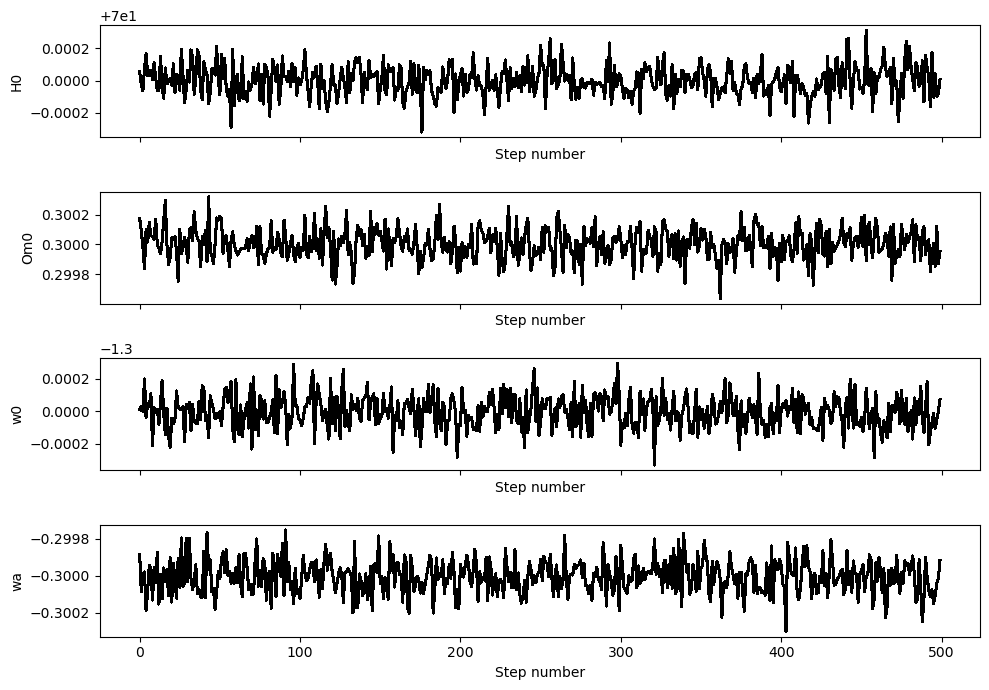

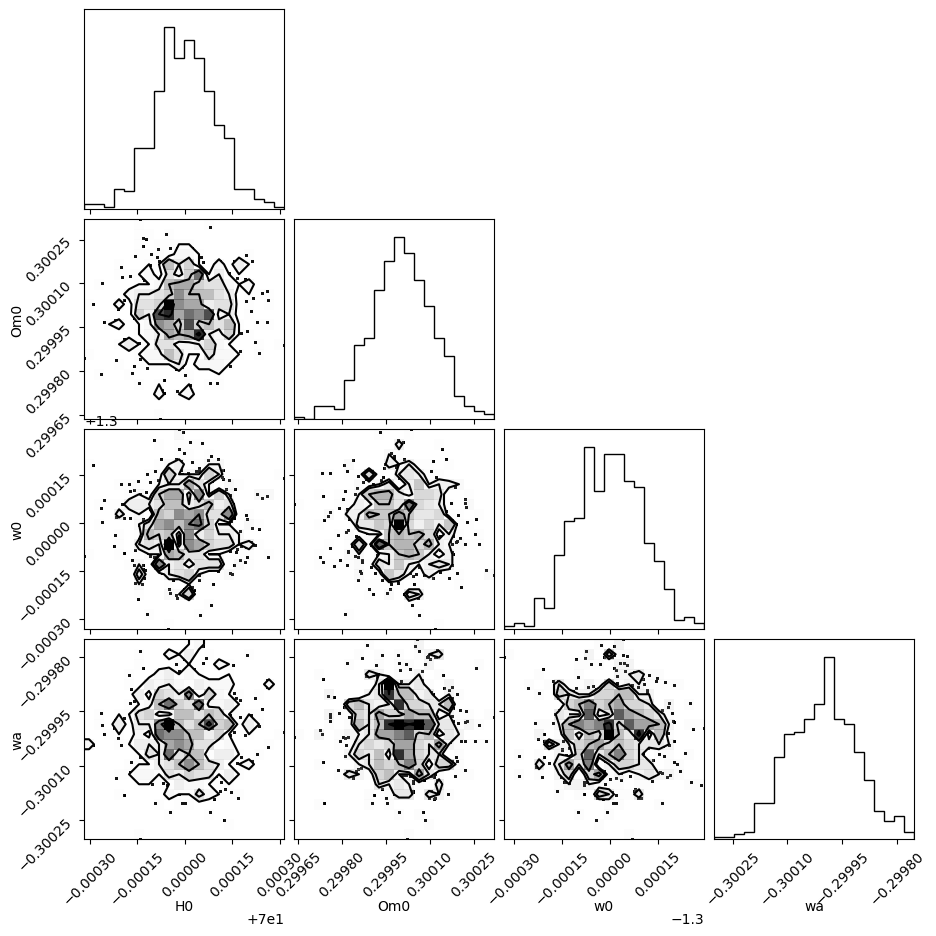

In [6]:
import sys
import platform
import os
import pandas as pd
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

_camb_path = os.path.join(os.path.dirname(os.path.abspath('.')), 'CAMB')
sys.path.insert(0, _camb_path)

import camb
print('Using CAMB %s installed at %s' % (camb.__version__, os.path.dirname(camb.__file__)))

# Load the data
file_path = 'lcparam_full_long.txt'

# Read the first line to get the header
with open(file_path, 'r') as file:
    header_line = file.readline().strip()
    header = header_line.lstrip('#').strip()

# Remove the last word from the header (assumed to be 'biascor')
header_words = header.split()
header_words.pop()
header = ' '.join(header_words)

# Read the rest of the file into a DataFrame
data = pd.read_csv(file_path, sep='\s+', skiprows=1, header=None)
data.columns = header.split()

# Extract relevant columns
d = data['mb'].values
dmb = data['dmb'].values

# Compute the covariance matrix
Sigma = np.diag(dmb**2)
Sigma_inv = np.linalg.inv(Sigma)

print(data.head())
print("Covariance Matrix (Sigma):")
print(Sigma)
print("Inverse Covariance Matrix (Sigma_inv):")
print(Sigma_inv)

def get_mu(z, H0, Om0, w0, wa):
    pars = camb.CAMBparams()
    pars.set_dark_energy(w=w0, wa=wa)
    pars.set_cosmology(H0=H0, ombh2=0.022, omch2=Om0*0.12)
    pars.InitPower.set_params(ns=0.965)
    results = camb.get_results(pars)
    
    # Debugging: Check if w crosses -1
    z = np.array([0.1, 0.5, 1.0])  # Example redshifts
    w = w0 + wa * (z / (1 + z))
    if np.any(w > -1):
        print(f"w crosses -1 at redshifts: {z[w > -1]}")

    # Get luminosity distance in Mpc
    dl = results.comoving_radial_distance(z) * (1 + z)
    
    # Convert to distance modulus
    mu = 5 * np.log10(dl) + 25
    return mu

def ln_likelihood(params, data, cov_inv):
    H0, Om0, w0, wa = params
    z = data['zcmb'].values
    d = data['mb'].values
    try:
        mu = get_mu(z, H0, Om0, w0, wa)
    except Exception as e:
        print(f"Error in get_mu: {e}")
        return -np.inf
    diff = d - mu
    term1 = -0.5 * diff @ cov_inv @ diff
    term2 = 0.5 * ((np.ones_like(diff) @ cov_inv @ diff) ** 2) / (np.ones_like(diff) @ cov_inv @ np.ones_like(diff))
    return term1 + term2

def log_prior(params):
    H0, Om0, w0, wa = params
    if not (60 < H0 < 80):
        return -np.inf
    if not (0.2 < Om0 < 0.4):
        return -np.inf
    if not (-1.3 < w0 < -0.8):
        return -np.inf
    if not (-1 < wa < 0):
        return -np.inf
    
    # Constraint to avoid crossing w = -1 (relaxed)
    if w0 + wa < -1:
        return -np.inf

    return 0.0

def log_posterior(params, data, cov_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(params, data, cov_inv)

# Initialize the MCMC sampler
initial = np.array([70, 0.3, -1.3, -0.3])
ndim = len(initial)
nwalkers = 500
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data, Sigma_inv))

# Run the MCMC sampler
nsteps = 10000
sampler.run_mcmc(pos, nsteps, progress=True)

# Get the samples
samples = sampler.get_chain(discard=100, thin=10, flat=True)

# Plot the chains for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = ["H0", "Om0", "w0", "wa"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:, :, i], color="k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.set_xlabel("Step number")

plt.tight_layout()
plt.show()

# Plot the results
fig = corner.corner(samples, labels=["H0", "Om0", "w0", "wa"])
plt.show()
